# Sea ice plotting examples

This script shows how to load and plot sea ice concentration from sea ice models (CICE5, and SIS2) output, while also indicating how to get around some of the pitfalls and foibles in CICE temporal and spatial gridding.

Requirements: The `conda/analysis3` module from `/g/data/hh5/public/modules`. 

In [1]:
#Choose which model we are working with
MODEL='cice5'
# MODEL='sis2'

Firstly, load modules:

In [2]:
import intake
from dask.distributed import Client
from datetime import timedelta
import cf_xarray as cfxr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.path as mpath
import cmocean.cm as cmo

In [3]:
client = Client(threads_per_worker=1)
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33217 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/33217/status,
Dashboard: /proxy/33217/status,Workers: 14
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42533,Workers: 14
Dashboard: /proxy/33217/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:32809,Total threads: 1
Dashboard: /proxy/44543/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:36485,


Open the catalog

In [4]:
catalog = intake.cat.access_nri

The dictionary below specifies experiment, start and ending times for each model we can use (CICE5 with MOM5 or SIS2 with MOM6). This example will work with RYF forcing experiments and sea ice concentration variable, which is called `aice_m` in mom5 and `siconc` in mom6.

If you want a different experiment, or a different time period, change the necessary values. Note that we are just loading the last 10 years here.

Note also the `decode_coords=False` flag. **This gets around some messy issues with the way xarray decides to load CICE grids**:

In [5]:
sic_args = {
    "cice5": { #cice5 is part of ACCESS-OM2
        "expt": "01deg_jra55v13_ryf9091",
        "variable": "aice_m",
        "decode_coords": False
    },
    "sis2": { #sis2 is used for testing MOM6
        "expt": "OM4_025.JRA_RYF",
        "variable": "siconc",
        "decode_coords": True
    },
    #In the future, we will add a CICE6 option (i.e. the future ACCESS-OM3)
}

area_variable = {
    "cice5": "area_t" ,
    "sis2": "areacello"
}

geo_variables = {
    "cice5":['geolon_t', 'geolat_t'] ,
    "sis2": ['geolon', 'geolat']
}

In [7]:
cat_subset = catalog[sic_args[MODEL]['expt']]
cat_subset

,unique
filename,3469
file_id,33
path,11947
filename_timestamp,3372
frequency,5
start_date,3361
end_date,3360
variable,205
variable_long_name,197
variable_standard_name,36


In [8]:
var_search = cat_subset.search(variable=sic_args[MODEL]['variable'], frequency="1mon")
var_search

,unique
filename,3360
file_id,1
path,3360
filename_timestamp,3360
frequency,1
start_date,3360
end_date,3360
variable,55
variable_long_name,55
variable_standard_name,1


In [9]:
darray = var_search.to_dask( 
    xarray_open_kwargs=dict(
        decode_coords = sic_args[MODEL]['decode_coords']
    ) , 
    xarray_combine_by_coords_kwargs=dict(
        compat="override",
        data_vars="minimal",
        coords="minimal"
    )
)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 13.40 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [10]:
darray = darray[sic_args[MODEL]['variable']]
darray = darray

In [11]:
sic = darray

**Another messy thing about CICE is that it thinks that monthly data for, say, January occurs at midnight on Jan 31 -- while xarray interprets this as the first milllisecond of February.**  
  
To get around this, note that we loaded data from February above, and we now subtract 12 hours from the time dimension. This means that, at least data is sitting in the correct month, and really helps to compute monthly climatologies correctly.

In [12]:
if MODEL =='cice5' :
    sic['time'] = sic.time.to_pandas() - timedelta(hours = 12)

In [13]:
sic = sic.sel(time=slice('1981','1990'))

In [14]:
sic

<xarray.DataArray 'aice_m' (time: 120, nj: 2700, ni: 3600)> Size: 5GB
dask.array<getitem, shape=(120, 2700, 3600), dtype=float32, chunksize=(1, 675, 900), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 960B 1981-01-31 12:00:00 ... 1990-12-31 12:00:00
Dimensions without coordinates: nj, ni
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    coordinates:    TLON TLAT time
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

In [15]:
sic = sic.chunk([3, 'auto', 'auto'])
sic

/jobfs/137134251.gadi-pbs/ipykernel_2407140/1065503372.py:1: DeprecationWarning: Supplying chunks as dimension-order tuples is deprecated. It will raise an error in the future. Instead use a dict with dimension names as keys.
  sic = sic.chunk([3, 'auto', 'auto'])


<xarray.DataArray 'aice_m' (time: 120, nj: 2700, ni: 3600)> Size: 5GB
dask.array<rechunk-merge, shape=(120, 2700, 3600), dtype=float32, chunksize=(3, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 960B 1981-01-31 12:00:00 ... 1990-12-31 12:00:00
Dimensions without coordinates: nj, ni
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    coordinates:    TLON TLAT time
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

Note that `aice_m` is the monthly average of fractional ice area in each grid cell aka the concentration. **To find the actual area of the ice we need to know the area of each cell. Unfortunately, CICE doesn't save this for us ... but the ocean model does.** So, let's load `area_t` from the ocean model, and rename the coordinates in our ice variable to match the ocean model. Then we can multiply the ice concentration with the cell area to get a total ice area.

In [16]:
var_search = cat_subset.search(variable=area_variable[MODEL])
var_search = var_search.search(path=var_search.df['path'][0])
darray = var_search.to_dask()
darray = darray[area_variable[MODEL]]
area = darray.load()
area

<xarray.DataArray 'area_t' (yt_ocean: 2700, xt_ocean: 3600)> Size: 39MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    geolon_t  (yt_ocean, xt_ocean) float32 39MB nan nan nan nan ... nan nan nan
    geolat_t  (yt_ocean, xt_ocean) float32 39MB nan nan nan nan ... nan nan nan
Attributes:
    long_name:     tracer cell area
    units:         m^2
    valid_range:   [0.e+00 1.e+15]
    cell_methods:  time: point

Our CICE data is missing x&y coordinate values, so we can also get them from area_t

So that our new coordinates are recognised as cf standard, we also need to copy the attributes. This notebook is designed to use `cf-xarray`. This means the rest of the notebook is [Model Agnostic](https://cosima-recipes.readthedocs.io/en/latest/Tutorials/Model_Agnostic_Analysis.html).

In [17]:
if MODEL =='cice5' :
    sic.coords['ni'] = area['xt_ocean'].values
    sic.coords['nj'] = area['yt_ocean'].values

    sic.ni.attrs = area.xt_ocean.attrs
    sic.nj.attrs = area.yt_ocean.attrs
    
    sic = sic.rename(({'ni': 'xt_ocean', 'nj': 'yt_ocean'}))

In [18]:
sic.cf

Coordinates:
             CF Axes: * X: ['xt_ocean']
                      * Y: ['yt_ocean']
                        Z, T: n/a

      CF Coordinates: * longitude: ['xt_ocean']
                      * latitude: ['yt_ocean']
                        vertical, time: n/a

       Cell Measures:   area, volume: n/a

      Standard Names:   n/a

              Bounds:   n/a

       Grid Mappings:   n/a

Now that we have axes with cf compliant coordinates, we can select using `latitude` keywords.

# Sea Ice Area

Let's look at a timeseries of SH sea ice area. Area is defined (per convention) as the sum of sea ice concentration multiply by the area of each grid cell (and masked for sea ice concentration above 15%)

By convention, sea-ice area for a region or basin is the sum of the area's where concentration is greater than 15%. 
We also need to drop geolon and geolat so we have unique longitude and latitude to reference

In [19]:
sic = sic.where(sic >= 0.15)

si_area = sic * area

if MODEL=='cice5':
    si_area = si_area.drop_vars({'geolon_t', 'geolat_t'})

In [20]:
si_area.cf

Coordinates:
             CF Axes: * X: ['xt_ocean']
                      * Y: ['yt_ocean']
                        Z, T: n/a

      CF Coordinates: * longitude: ['xt_ocean']
                      * latitude: ['yt_ocean']
                        vertical, time: n/a

       Cell Measures:   area, volume: n/a

      Standard Names:   n/a

              Bounds:   n/a

       Grid Mappings:   n/a

In [21]:
SH_area = si_area.cf.sel(latitude=slice(-90, -45)).cf.sum(['latitude', 'longitude'])
NH_area = si_area.cf.sel(latitude=slice(45, 90)).cf.sum(['latitude', 'longitude'])

As we are using a repeat year forcing experiemnt, the sea ice cycle is very regular:

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 38.30 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


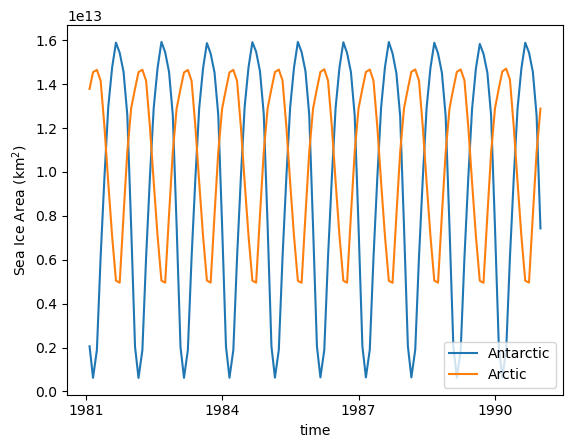

In [22]:
SH_area.plot(label = 'Antarctic')
NH_area.plot(label = 'Arctic')

plt.legend(loc='lower right')
plt.ylabel('Sea Ice Area (km$^{2}$)');

And the seasonal cycle of sea-ice area:

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 38.35 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 38.35 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Text(0, 0.5, 'Sea Ice Area (km$^{2}$)')

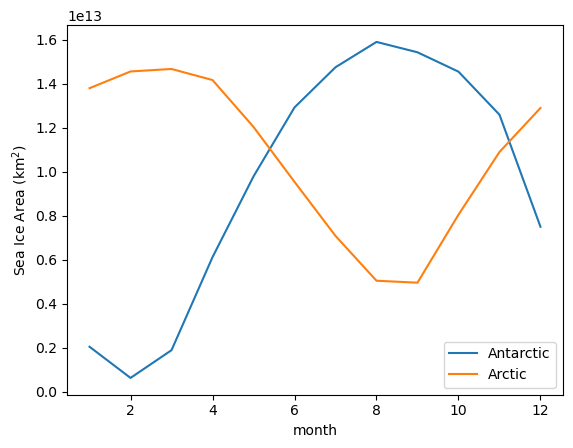

In [23]:
SH_area.groupby('time.month').mean('time').plot(label='Antarctic')
NH_area.groupby('time.month').mean('time').plot(label='Arctic')

plt.legend()
plt.ylabel('Sea Ice Area (km$^{2}$)')

# Making Maps

If we just plot a selected month now, you see that everything North of 65N is skewed. 

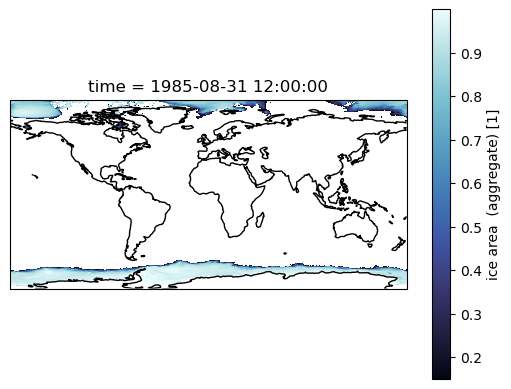

In [26]:
ax = plt.subplot(projection = ccrs.PlateCarree())

sic.sel(time='1985-08').plot(cmap = cmo.ice)
ax.coastlines()

Most of our work is in the Southern Ocean, so maybe we don't care. But if you are interested in the Arctic, then we need to account for the tri-polar ocean grid that out models use. The easiest way out of that is using contourf, and the passing the x and y coordinates.

See [Making Maps with Cartopy](https://cosima-recipes.readthedocs.io/en/latest/Tutorials/Making_Maps_with_Cartopy.html) tutorial for more help with plotting!

We need the geolon and geolat fields from the model for the actual (two-pole) coordinates, instead of the model (three-pole) coordinates.

In [25]:
sic=sic.assign_coords({
    'geolat': area.geolat_t,
    'geolon': area.geolon_t
})

Use contourf, and the geolon and geolat fields

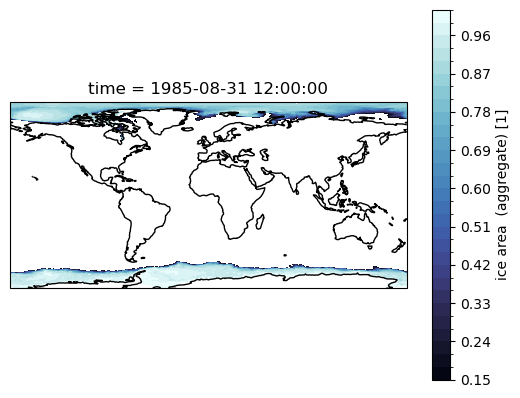

In [27]:
ax = plt.subplot(projection=ccrs.PlateCarree())

sic.sel(time='1985-08').squeeze('time').plot.contourf(
    transform = ccrs.PlateCarree(),
    x = 'geolon',
    y = 'geolat',
    levels = 33,
    cmap = cmo.ice
)

ax.coastlines()

Using cartopy, we can make Polar Stereographic plots of sea ice concentration for a selected month, as follows:

In [28]:
def plot_si_conc(data):
    """ A function for plotting tri-polar data"""
    ax = plt.gca()

    # Map the plot boundaries to a circle
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

    # Add land features and gridlines
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black',
                   facecolor = 'gainsboro'), zorder = 2)

    data.plot.contourf(
        transform = ccrs.PlateCarree(),
        x = 'geolon', 
        y = 'geolat', 
        levels = np.arange(0.15, 1.05, 0.05),
        cmap = cmo.ice,
        cbar_kwargs = {
            'label':'Sea Ice Concentration'
        }
    )

    gl = ax.gridlines(
            draw_labels=True, linewidth=1, color='gray', alpha=0.2, linestyle='--',
            ylocs = np.arange(-80, 81, 10)
        )

    ax.coastlines()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


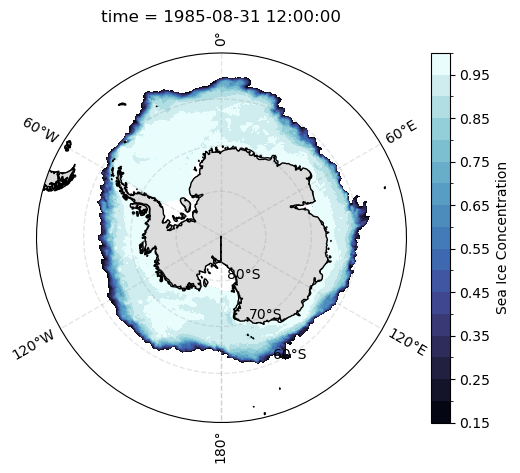

In [29]:
def plot_sh_si_conc():
    ax = plt.subplot(projection=ccrs.SouthPolarStereo())

    ax.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())

    plot_si_conc(
        sic.cf.sel(time='1985-08').squeeze('time')
    )

plot_sh_si_conc()

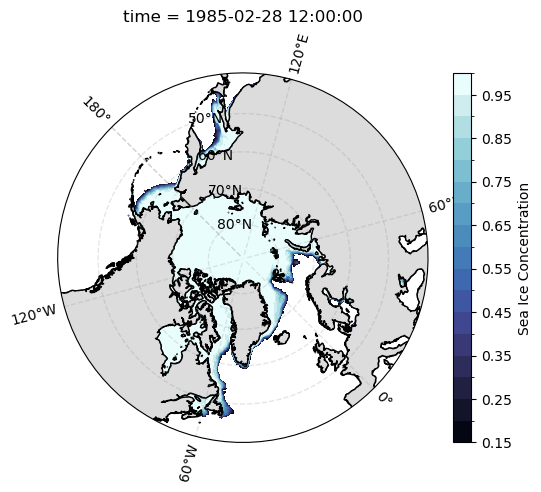

In [37]:
def plot_nh_si_conc():
    ax = plt.subplot(projection=ccrs.NorthPolarStereo(central_longitude=-45))
    
    ax.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())

    plot_si_conc(
        sic.cf.sel(time='1985-02').squeeze('time')
    )

plot_nh_si_conc()

Once we are happy with your plot, we can save the plot to disk using `plt.savefig('filepath/filename')` function at the end of the cell containing the plot we want to save, as shown below. Note that your filename must contain the file (e.g., pdf, jpeg, png, etc.).  
For more information on the options available to save figures refer to [Matplotlib documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html).

```python
plot_sh_si_conc()
plt.savefig('MyFirstSeaIcePlot.png', dpi = 300)
```